# Convolutional Neural Network State Discrimination Demo

Quantum state discrimination (QSD) of optical quantum states using a convolutional neural network (CNN) clasifier.

## Install libraries to runtime

If running in Google Colab, run the following setup cell once each time you open your project in order to install non-default package dependencies to the runtime. DO NOT RUN if you have already created a kernel with `qsttoolkit` as per the setup instructions in `README.md`.

In [ ]:
!pip install qsttoolkit

## Imports

All of QSTToolkit's features can be accessed by importing `qsttoolkit` and calling them directly. Most features sit within two main subpackages: `.data` and `.tomography`. In this example notebook, functions are called from their subpackage where relevant to show which features sit in each subpackage, and which lie in modules outside either:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qutip as qt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import qsttoolkit as qst

## Data Preparation

We first create batches of optical quantum states of seven different varieties. `qsttoolkit.data` provides classes to produce such batches, each state with randomized parameters within given limits, based on the [QuTiP](https://qutip.org/docs/4.0.2/index.html) framework:

In [ ]:
dim = 32            # Dimensionality of the Hilbert space of the system

fock_batch = qst.data.FockStates(n_states = 1000,
                                 dim = dim,
                                 n_range = [0, dim])
coherent_batch = qst.data.CoherentStates(n_states = 1000,
                                         dim = dim,
                                         alpha_magnitude_range = [1e-6, 3])
thermal_batch = qst.data.ThermalStates(n_states = 1000,
                                       dim = dim,
                                       nbar_range = [0, dim])
num_batch = qst.data.NumStates(n_states = 1000,
                               dim = dim,
                               types = ['17', 'M', 'P', 'P2', 'M2'])
binomial_batch = qst.data.BinomialStates(n_states = 1000,
                                         dim = dim,
                                         S_range = [1, 10],
                                         mu_range = [0, 2])
cat_batch = qst.data.CatStates(n_states = 1000,
                               dim = dim,
                               alpha_magnitude_range = [0, 10])
random_batch = qst.data.RandomStates(n_states = 1000,
                                     dim = dim)

print('States generated')

/content/drive/MyDrive/Google_Colab/qsttoolkit/data/state_batches.py:164: UserWarning: thermal states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.
  warnings.warn("thermal states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.")


States generated


/content/drive/MyDrive/Google_Colab/qsttoolkit/data/state_batches.py:356: UserWarning: Random states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.
  warnings.warn("Random states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.")


Parameters for noise sources that are applied to the density matrix and Husimi Q data:

In [ ]:
mixed_state_noise_level = 0.1         # Mixed state noise coefficient
affine_theta = 20.0                   # Maximum affine transformation theta
affine_x = 0.1                        # Maximum affine transformation x shift
affine_y = 0.1                        # Maximum affine transformation y shift
additive_Gaussian_stddev = 0.01       # Additive Gaussian noise distribution standard deviation
amplification_ntherm = 1.0            # Variance of the Gaussian convolution kernel
pepper_p = 0.01                       # Pepper noise pixel probability
salt_p = 0.0                          # Salt noise pixel probability

We initialize the Husimi Q phase space before creating measurement data:

In [ ]:
data_dim = 32                 # Dimensions of the phase space grid that will serve as the image size for our data
xgrid = np.linspace(-5, 5, data_dim)
pgrid = np.linspace(-5, 5, data_dim)

We then create density matrices and Husimi Q measurement images, applying mixed state noise using `qsttoolkit.data.mixed_state_noise()` and measurement noise using `qsttoolkit.data.apply_measurement_noise()`:

In [ ]:
fock_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
coherent_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
thermal_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
num_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
binomial_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
cat_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
random_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
print("DataFrames initialized")

fock_densities = [qst.data.mixed_state_noise(dm, mixed_state_noise_level) for dm in fock_batch.density_matrices()]
fock_data['label'] = ['fock']*len(fock_densities)
fock_data['density_matrix'] = [dm.full() for dm in fock_densities]
fock_data['Husimi-Q_function'] = [qst.data.apply_measurement_noise(qt.qfunc(dm, xgrid, pgrid), affine_theta=affine_theta, affine_x=affine_x, affine_y=affine_y, amplification_ntherm=amplification_ntherm, additive_Gaussian_stddev=additive_Gaussian_stddev, pepper_p=pepper_p, salt_p=salt_p) for dm in fock_densities]
fock_data['state_parameter'] = fock_batch.params
print("Fock data generated")

coherent_densities = [qst.data.mixed_state_noise(dm, mixed_state_noise_level) for dm in coherent_batch.density_matrices()]
coherent_data['label'] = ['coherent']*len(coherent_densities)
coherent_data['density_matrix'] = [dm.full() for dm in coherent_densities]
coherent_data['Husimi-Q_function'] = [qst.data.apply_measurement_noise(qt.qfunc(dm, xgrid, pgrid), affine_theta=affine_theta, affine_x=affine_x, affine_y=affine_y, amplification_ntherm=amplification_ntherm, additive_Gaussian_stddev=additive_Gaussian_stddev, pepper_p=pepper_p, salt_p=salt_p) for dm in coherent_densities]
coherent_data['state_parameter'] = coherent_batch.params
print("Coherent data generated")

thermal_densities = [qst.data.mixed_state_noise(dm, mixed_state_noise_level) for dm in thermal_batch.density_matrices()]
thermal_data['label'] = ['thermal']*len(thermal_densities)
thermal_data['density_matrix'] = [dm.full() for dm in thermal_densities]
thermal_data['Husimi-Q_function'] = [qst.data.apply_measurement_noise(qt.qfunc(dm, xgrid, pgrid), affine_theta=affine_theta, affine_x=affine_x, affine_y=affine_y, amplification_ntherm=amplification_ntherm, additive_Gaussian_stddev=additive_Gaussian_stddev, pepper_p=pepper_p, salt_p=salt_p) for dm in thermal_densities]
thermal_data['state_parameter'] = thermal_batch.params
print("Thermal data generated")

num_densities = [qst.data.mixed_state_noise(dm, mixed_state_noise_level) for dm in num_batch.density_matrices()]
num_data['label'] = ['num']*len(num_densities)
num_data['density_matrix'] = [dm.full() for dm in num_densities]
num_data['Husimi-Q_function'] = [qst.data.apply_measurement_noise(qt.qfunc(dm, xgrid, pgrid), affine_theta=affine_theta, affine_x=affine_x, affine_y=affine_y, amplification_ntherm=amplification_ntherm, additive_Gaussian_stddev=additive_Gaussian_stddev, pepper_p=pepper_p, salt_p=salt_p) for dm in num_densities]
num_data['state_parameter'] = num_batch.params
print("Num data generated")

binomial_densities = [qst.data.mixed_state_noise(dm, mixed_state_noise_level) for dm in binomial_batch.density_matrices()]
binomial_data['label'] = ['binomial']*len(binomial_densities)
binomial_data['density_matrix'] = [dm.full() for dm in binomial_densities]
binomial_data['Husimi-Q_function'] = [qst.data.apply_measurement_noise(qt.qfunc(dm, xgrid, pgrid), affine_theta=affine_theta, affine_x=affine_x, affine_y=affine_y, amplification_ntherm=amplification_ntherm, additive_Gaussian_stddev=additive_Gaussian_stddev, pepper_p=pepper_p, salt_p=salt_p) for dm in binomial_densities]
binomial_data['state_parameter'] = binomial_batch.params
print("Binomial data generated")

cat_densities = [qst.data.mixed_state_noise(dm, mixed_state_noise_level) for dm in cat_batch.density_matrices()]
cat_data['label'] = ['cat']*len(cat_densities)
cat_data['density_matrix'] = [dm.full() for dm in cat_densities]
cat_data['Husimi-Q_function'] = [qst.data.apply_measurement_noise(qt.qfunc(dm, xgrid, pgrid), affine_theta=affine_theta, affine_x=affine_x, affine_y=affine_y, amplification_ntherm=amplification_ntherm, additive_Gaussian_stddev=additive_Gaussian_stddev, pepper_p=pepper_p, salt_p=salt_p) for dm in cat_densities]
cat_data['state_parameter'] = cat_batch.params
print("Cat data generated")

random_densities = [qst.data.mixed_state_noise(dm, mixed_state_noise_level) for dm in random_batch.density_matrices()]
random_data['label'] = ['random']*len(random_densities)
random_data['density_matrix'] = [dm.full() for dm in random_densities]
random_data['Husimi-Q_function'] = [qst.data.apply_measurement_noise(qt.qfunc(dm, xgrid, pgrid), affine_theta=affine_theta, affine_x=affine_x, affine_y=affine_y, amplification_ntherm=amplification_ntherm, additive_Gaussian_stddev=additive_Gaussian_stddev, pepper_p=pepper_p, salt_p=salt_p) for dm in random_densities]
random_data['state_parameter'] = random_batch.params
print("Random data generated")

data = pd.concat([fock_data, coherent_data, thermal_data, num_data, binomial_data, cat_data, random_data])
data = data.sample(frac=1).reset_index(drop=True)
print("Dataset generated")

DataFrames initialized
Fock data generated
Coherent data generated
Thermal data generated
Num data generated
Binomial data generated
Cat data generated
Random data generated
Dataset generated


Alternatively, QSTToolkit provides `optical_state_dataset()` which produces the above dataset in one function, intended to be used as a standardized dataset for training models. All the implemented noise sources are applied to the generated data, with levels that can be adjusted in the arguments:

In [ ]:
data = qst.data.optical_state_dataset(dim=32,
                                      data_dim=32,
                                      state_numbers=[1000, 1000, 1000, 1000, 1000, 1000, 0, 1000],       # Large numbers of GKP states take an intractable amount of time to produce, and are difficult to produce practically
                                      mixed_state_noise_level = 0.1,
                                      affine_theta = 20.0,
                                      affine_x = 0.1,
                                      affine_y = 0.1,
                                      additive_Gaussian_stddev = 0.01,
                                      amplification_ntherm = 1.0,
                                      pepper_p = 0.01,
                                      salt_p = 0.0)

Fock states generated
Coherent states generated
Thermal states generated
Num states generated


/content/drive/MyDrive/Google_Colab/qsttoolkit/data/state_batches.py:164: UserWarning: thermal states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.
  warnings.warn("thermal states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.")


Binomial states generated
Cat states generated
GKP states generated
Random states generated
DataFrames initialized


/content/drive/MyDrive/Google_Colab/qsttoolkit/data/state_batches.py:356: UserWarning: Random states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.
  warnings.warn("Random states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.")
<ipython-input-7-da2f9d2aafa5>:1: FutureWarning: The column 'Husimi-Q' will be renamed to 'Husimi_Q' in the next major update.
  data = qst.data.optical_state_dataset(dim=32,


Fock data generated
Coherent data generated
Thermal data generated
Num data generated
Binomial data generated
Cat data generated
GKP data generated
Random data generated
Dataset generated


Inspect our dataset:

In [ ]:
data.head()

,label,density_matrix,Husimi-Q_function,state_parameter
0,thermal,[[(0.30295016345731984+7.377719693437687e-21j)...,"[[0.008321153080928723, 0.0, 0.0, 0.0, 0.00043...",2.000000+0.000000j
1,binomial,[[(0.03200823428098333-1.0394564036728117e-20j...,"[[0.0, 0.0, 0.0, 0.0, 0.006377612945044463, 0....",3.000000+0.000000j
2,cat,[[(0.008274881133967744-9.240922513690974e-21j...,"[[0.0, 0.0, 0.007158491973298466, 0.0, 0.01677...",7.779928-4.521996j
3,cat,[[(0.0030022562410647537+2.4664294803228134e-2...,"[[0.0, 0.0, 0.0, 0.006899173415320889, 0.0, 0....",4.992285-0.489887j
4,num,[[(0.0029307173587882302+1.387087913456339e-20...,"[[0.007769363084366395, 0.003947711475420815, ...",4.335775+0.000000j


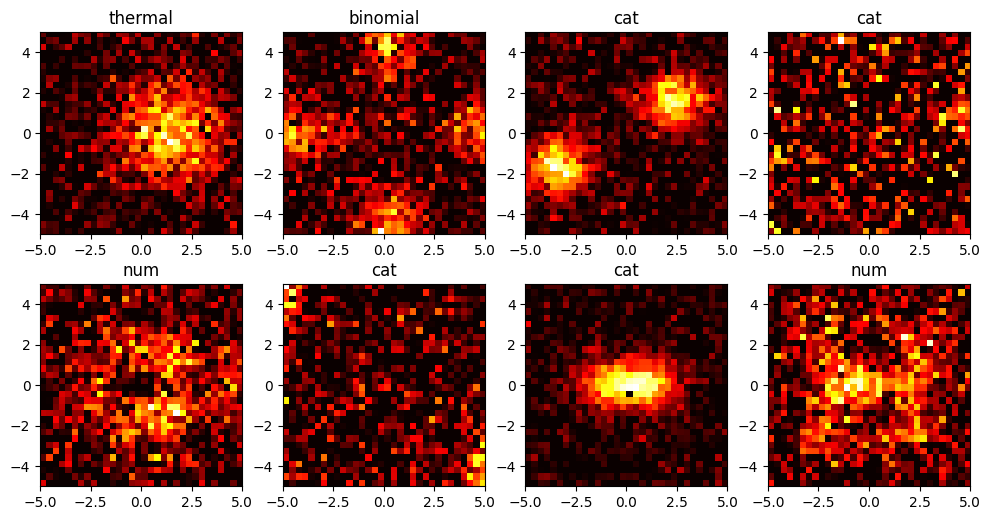

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs[0,0].imshow(data['Husimi-Q_function'][0], extent=[-5,5,-5,5], cmap='hot')
axs[0,0].set_title(data['label'][0])
axs[0,1].imshow(data['Husimi-Q_function'][1], extent=[-5,5,-5,5], cmap='hot')
axs[0,1].set_title(data['label'][1])
axs[0,2].imshow(data['Husimi-Q_function'][2], extent=[-5,5,-5,5], cmap='hot')
axs[0,2].set_title(data['label'][2])
axs[0,3].imshow(data['Husimi-Q_function'][3], extent=[-5,5,-5,5], cmap='hot')
axs[0,3].set_title(data['label'][3])
axs[1,0].imshow(data['Husimi-Q_function'][4], extent=[-5,5,-5,5], cmap='hot')
axs[1,0].set_title(data['label'][4])
axs[1,1].imshow(data['Husimi-Q_function'][5], extent=[-5,5,-5,5], cmap='hot')
axs[1,1].set_title(data['label'][5])
axs[1,2].imshow(data['Husimi-Q_function'][6], extent=[-5,5,-5,5], cmap='hot')
axs[1,2].set_title(data['label'][6])
axs[1,3].imshow(data['Husimi-Q_function'][7], extent=[-5,5,-5,5], cmap='hot')
axs[1,3].set_title(data['label'][7])
plt.show()

## Modelling

Data preprocessing:

In [ ]:
X = data['Husimi-Q_function']
y_raw = data['label']
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y_raw)

X_train, X_test, y_train, y_test = train_test_split(X, y_int, test_size=0.2, random_state=42)

data_dim = X_train[0].shape[0]
X_train = np.array([x for x in X_train]).reshape(-1, data_dim, data_dim, 1)
X_test = np.array([x for x in X_test]).reshape(-1, data_dim, data_dim, 1)

We create an instance of the `qsttoolkit.tomography.CNNQuantumStateDiscrimination` class, which handles the model architecture, compiling and training:

In [ ]:
state_discriminator = qst.tomography.CNNQuantumStateDiscrimination(X_train=X_train,
                                                                   X_test=X_test,
                                                                   y_train=y_train,
                                                                   y_test=y_test,
                                                                   label_encoder=label_encoder,
                                                                   early_stopping_patience=3,
                                                                   lr_scheduler_factor=0.5,
                                                                   lr_scheduler_patience=2)

Model compiling and training using the `.train()` method:

In [ ]:
state_discriminator.train(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'],
                          epochs=50,
                          batch_size=32,
                          validation_split=0.2)

Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.2665 - loss: 1.7738 - val_accuracy: 0.5955 - val_loss: 1.0687 - learning_rate: 0.0010
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6439 - loss: 0.9733 - val_accuracy: 0.7768 - val_loss: 0.5996 - learning_rate: 0.0010
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7931 - loss: 0.5861 - val_accuracy: 0.7920 - val_loss: 0.5891 - learning_rate: 0.0010
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8332 - loss: 0.4681 - val_accuracy: 0.8607 - val_loss: 0.3965 - learning_rate: 0.0010
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8741 - loss: 0.3659 - val_accuracy: 0.8696 - val_loss: 0.3476 - learning_rate: 0.0010
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8788 - loss: 0.3337 - val_accuracy: 0.8464 - val_loss: 0.3852 - learning_rate: 0.0010
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8957 - loss: 0.3062 - 

## Analysis and Evaluation

Inspection of accuracy and loss over training epochs:

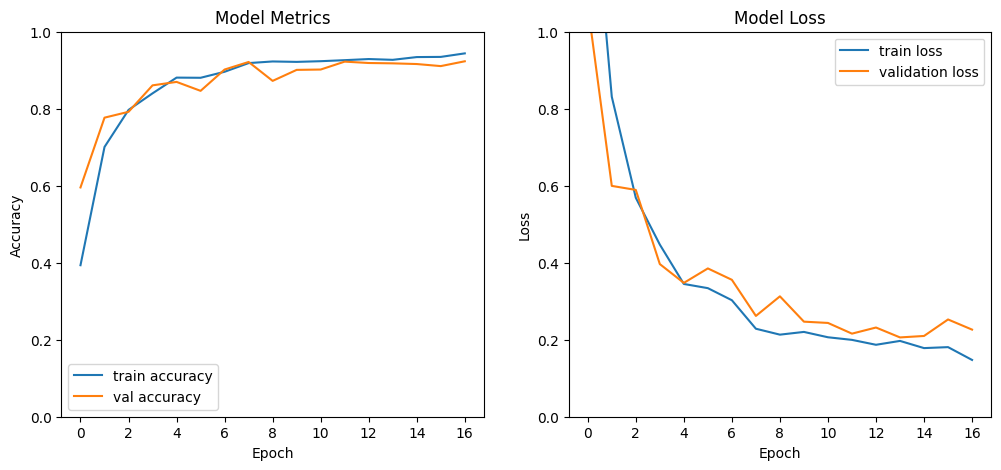

In [ ]:
state_discriminator.plot_training()

Model evaluation:

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


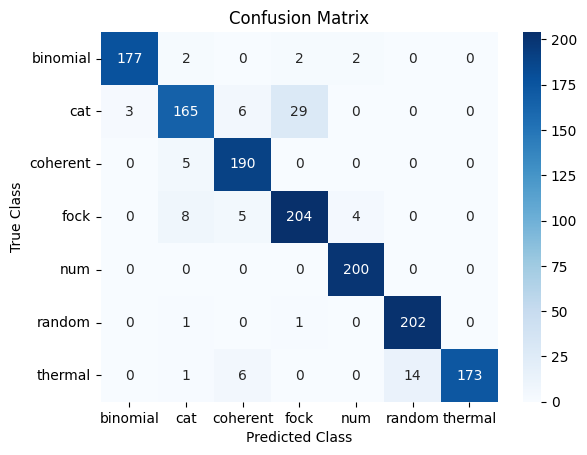

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       183
           1       0.91      0.81      0.86       203
           2       0.92      0.97      0.95       195
           3       0.86      0.92      0.89       221
           4       0.97      1.00      0.99       200
           5       0.94      0.99      0.96       204
           6       1.00      0.89      0.94       194

    accuracy                           0.94      1400
   macro avg       0.94      0.94      0.94      1400
weighted avg       0.94      0.94      0.94      1400



In [ ]:
state_discriminator.evaluate_classification(include_confusion_matrix=True, include_classification_report=True)

Built-in `.classify()` method to classify given input measurements and invert the label encoding, returning simply an array of label strings:

In [ ]:
print(state_discriminator.classify(X_test))

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
['num' 'binomial' 'coherent' ... 'num' 'num' 'thermal']


`CNNQuantumStateDiscrimination.model` can be treated as a `tensorflow.keras.Model` object, for example:

In [ ]:
state_discriminator.model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 477,719 (1.82 MB)

 Trainable params: 159,239 (622.03 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 318,480 (1.21 MB)